In [ ]:
!rm -rf /content/Self-Correction-Human-Parsing/outputs

This colab file is demo for Self Correction Human Parsing.
</br> Please select GPU as runtime before running the code

In [ ]:
!pip install ninja

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 2.3 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/PeikeLi/Self-Correction-Human-Parsing
%cd Self-Correction-Human-Parsing
!mkdir checkpoints
!mkdir inputs
!mkdir outputs

Cloning into 'Self-Correction-Human-Parsing'...
remote: Enumerating objects: 719, done.
remote: Counting objects: 100% (719/719), done.
remote: Compressing objects: 100% (568/568), done.
remote: Total 719 (delta 149), reused 610 (delta 140), pack-reused 0
Receiving objects: 100% (719/719), 3.88 MiB | 17.50 MiB/s, done.
Resolving deltas: 100% (149/149), done.
/content/Self-Correction-Human-Parsing


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/smaple_women_dataset.zip /content/Self-Correction-Human-Parsing/inputs/dataset.zip
import zipfile
%cd "/content/Self-Correction-Human-Parsing/inputs"
with zipfile.ZipFile('dataset.zip', 'r') as file:
    file.extractall()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/Self-Correction-Human-Parsing/inputs


In [ ]:
%cd "/content/Self-Correction-Human-Parsing"

/content/Self-Correction-Human-Parsing


Select dataset below

In [ ]:
dataset = 'lip'         #select from ['lip', 'atr', 'pascal']

In [ ]:
import gdown

if dataset == 'lip':
    url = 'https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH'
elif dataset == 'atr':
    url = 'https://drive.google.com/uc?id=1ruJg4lqR_jgQPj-9K0PP-L2vJERYOxLP'
elif dataset == 'pascal':
    url = 'https://drive.google.com/uc?id=1E5YwNKW2VOEayK9mWCS3Kpsxf-3z04ZE'

output = 'checkpoints/final.pth'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH
To: /content/Self-Correction-Human-Parsing/checkpoints/final.pth
100%|██████████| 267M/267M [00:03<00:00, 83.2MB/s]


'checkpoints/final.pth'

In [ ]:
#Please select images which you want to upload
%cd inputs
from google.colab import files
uploaded = files.upload()
%cd ..

In [ ]:
!python3 simple_extractor.py --dataset 'lip' --model-restore 'checkpoints/final.pth' --input-dir 'inputs/data' --output-dir 'outputs' --logits

Evaluating total class number 20 with ['Background', 'Hat', 'Hair', 'Glove', 'Sunglasses', 'Upper-clothes', 'Dress', 'Coat', 'Socks', 'Pants', 'Jumpsuits', 'Scarf', 'Skirt', 'Face', 'Left-arm', 'Right-arm', 'Left-leg', 'Right-leg', 'Left-shoe', 'Right-shoe']
100% 1/1 [00:01<00:00,  1.29s/it]


# Download the generated images from *outputs* folder

In [ ]:
import numpy as np
from google.colab.patches import cv2_imshow
import cv2, random

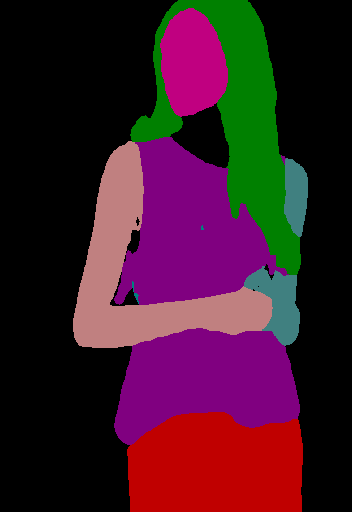

In [ ]:
parsing_image = cv2.imread("/content/Self-Correction-Human-Parsing/outputs/image.png")
cv2_imshow(parsing_image)

In [ ]:
dataset = np.load('/content/Self-Correction-Human-Parsing/outputs/image.npy', encoding='bytes')
dataset.shape

(512, 352, 20)

In [ ]:
cv2_imshow(dataset[:, :, 15])

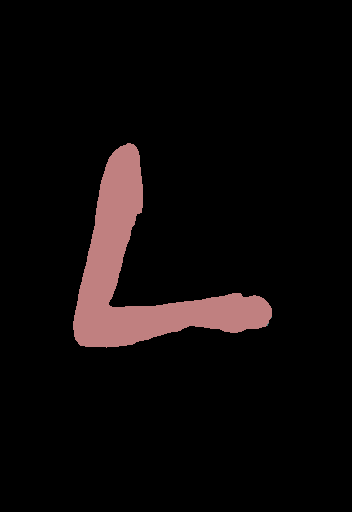

In [ ]:
selected_class_index = 15

selected_class_mask_values = dataset[:, :, selected_class_index]

threshold = 6
# Create a mask based on the threshold
selected_class_mask = selected_class_mask_values >= threshold

selected_class_pixels = parsing_image.copy()
selected_class_pixels[~selected_class_mask] = 0
cv2_imshow(selected_class_pixels)

In [ ]:
input_image = cv2.imread("/content/Self-Correction-Human-Parsing/inputs/data/image.png")
cv2_imshow(input_image)

In [ ]:
mask = cv2.imread("/content/Self-Correction-Human-Parsing/inputs/mask.png")
cv2_imshow(mask)

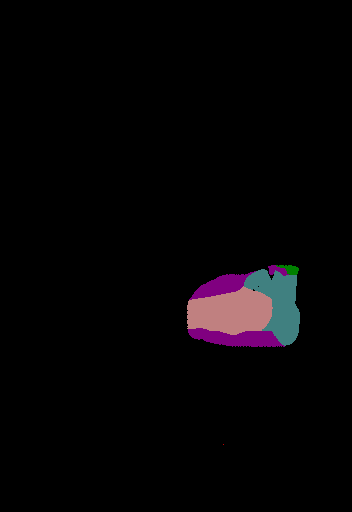

In [ ]:
# Overlay the mask on the parsing image
overlay = cv2.bitwise_and(parsing_image, parsing_image, mask=mask[:,:,2])
cv2_imshow(overlay)


In [ ]:
for class_index in range(dataset.shape[-1]):

    class_data  = dataset[:, :, class_index]

    threshold = 6
    # Create a mask based on the threshold
    class_data_mask = class_data >= threshold

    class_data_pixels = parsing_image.copy()
    class_data_pixels[~class_data_mask] = 0
    # cv2_imshow(class_data_pixels)


    overlap = cv2.bitwise_and(class_data_pixels, class_data_pixels, mask=mask[:,:,2])
    # cv2_imshow(overlap)
    if np.any(overlap):
      print(class_index)

2
5
9
14
15


# Distortion

# Glitch

# Blurry

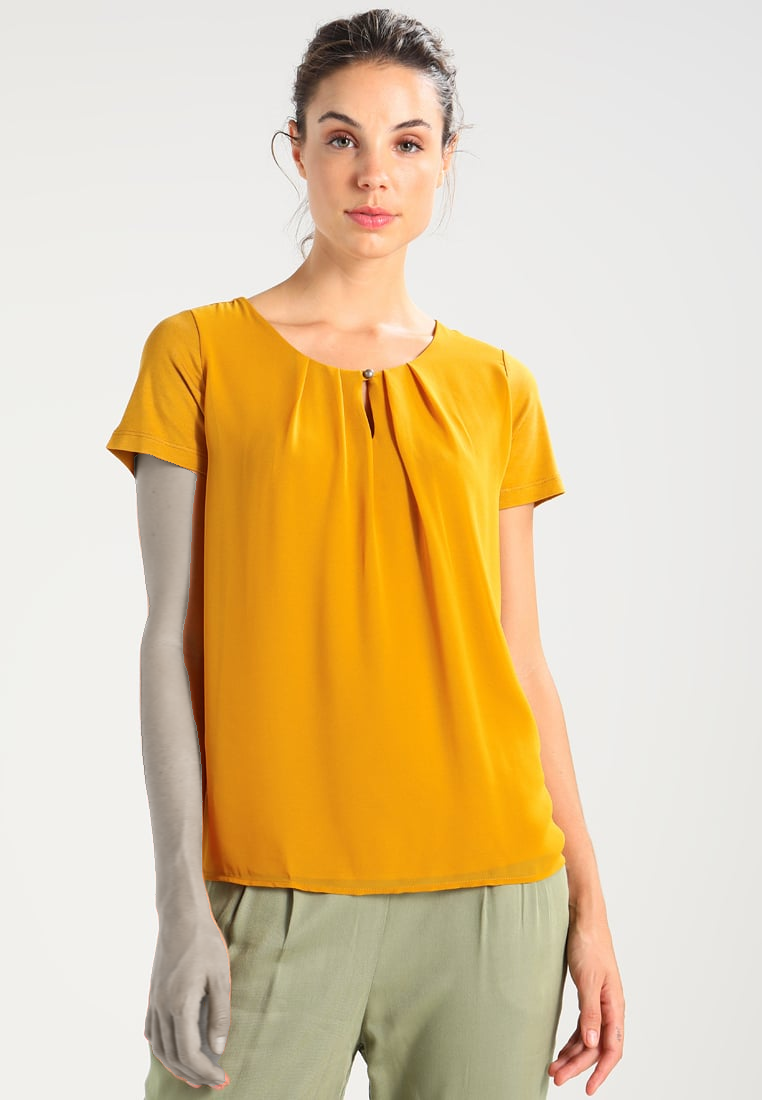

In [ ]:
# Copy input image
blurry_image = input_image.copy()

# Apply Gaussian blur to the masked region
blurred_region = cv2.GaussianBlur(blurry_image[selected_class_mask], (5, 5), 0)

# Place the blurred region back into the original image
blurry_image[selected_class_mask] = blurred_region

cv2_imshow(blurry_image)

# Color Distortion
Swap color channels

Skin color

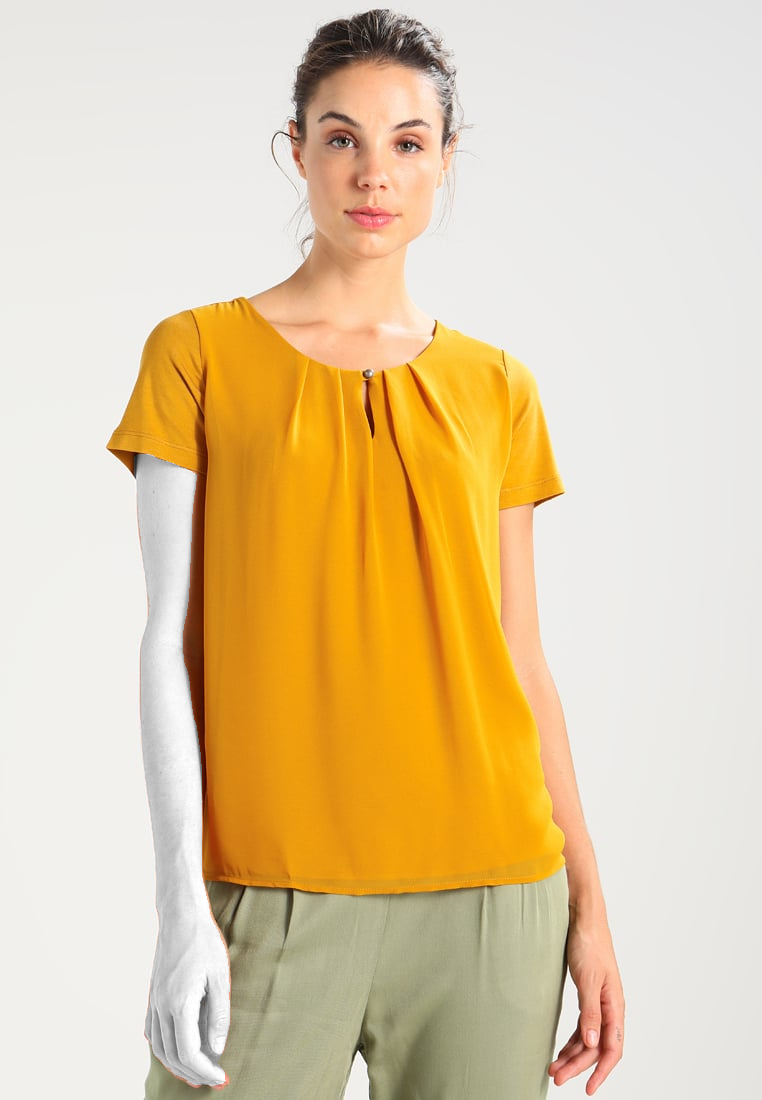

In [ ]:
# Copy input image
color_image = input_image.copy()

# Make sure the image and mask have the same dimensions
if color_image.shape[:2] != selected_class_mask.shape:
    raise ValueError("Image and segmentation mask dimensions do not match")

# Extract the selected region
selected_region = color_image[selected_class_mask]

# Apply color distortion to the selected region
distorted_region = selected_region.copy()

# Example color distortion: swap color channels
distorted_region[:, 0], distorted_region[:, 1] = distorted_region[:, 2], distorted_region[:, 0]

# Place the distorted region back into the original image
color_image[selected_class_mask] = distorted_region


cv2_imshow(color_image)

# Lighting Inconsistencies

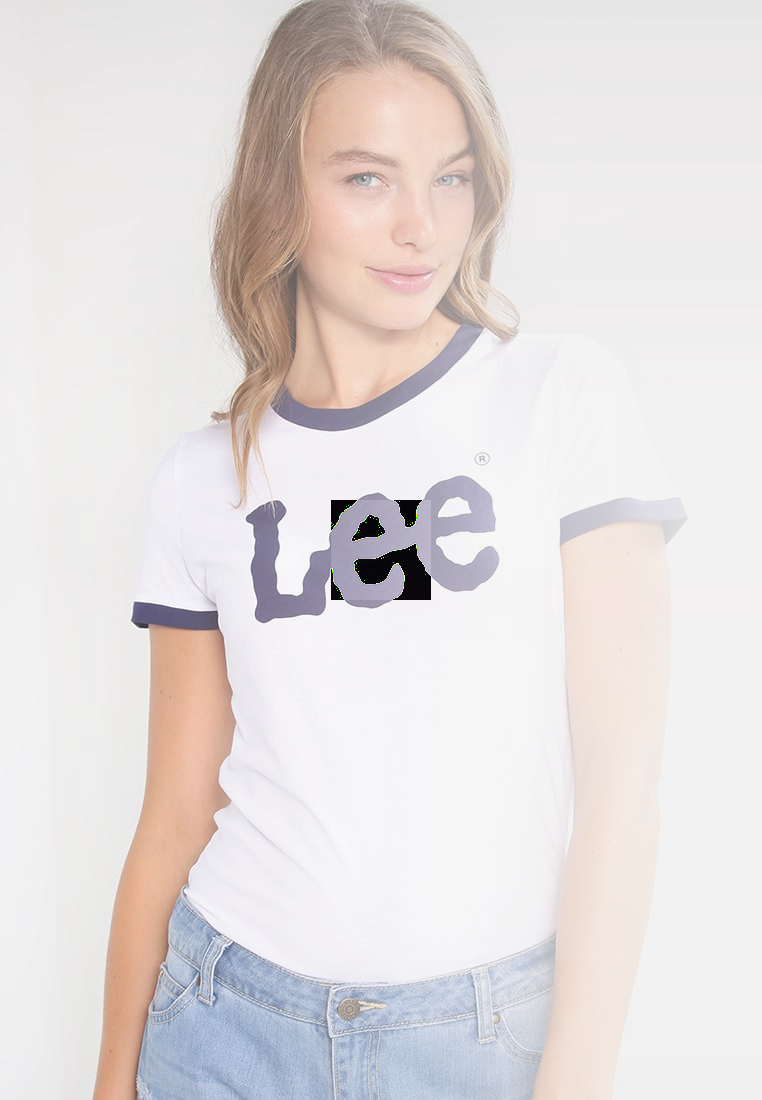

In [ ]:
# Copy input image
lighting_image = input_image.copy()

# Apply subtle lighting effects
height, width = lighting_image.shape[:2]

# Add a subtle gradient from left to right
for y in range(height):
    for x in range(width):
        alpha = x / width  # Adjust this value to control the strength of the effect
        lighting_image[y, x] = cv2.addWeighted(lighting_image[y, x], 1 - alpha, lighting_image[y, width - 1], alpha, 0).ravel()

# Increase brightness in the center
brightness_increase = 20  # Adjust this value to control the brightness increase
center_x = width // 2
center_y = height // 2
lighting_image[center_y - 50:center_y + 50, center_x - 50:center_x + 50] += brightness_increase

cv2_imshow(lighting_image)

# Disconnected

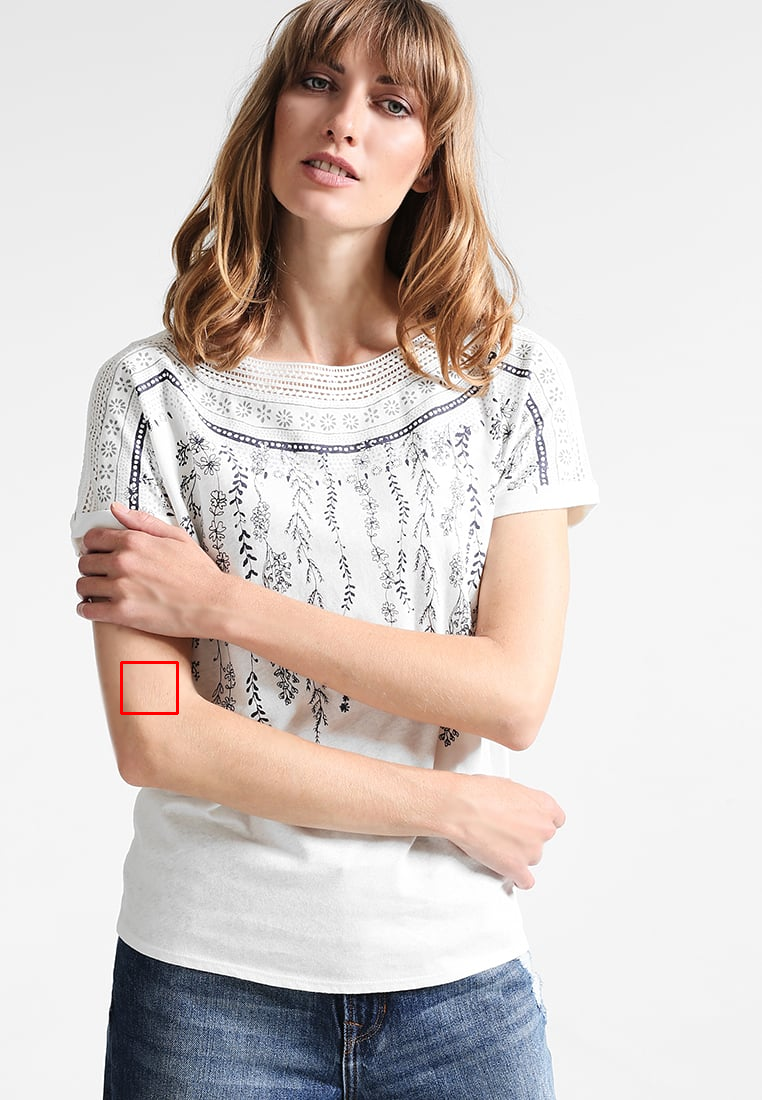

In [ ]:
# Copy input image
disconnected_image = input_image.copy()

image_height, image_width, _ = input_image.shape
rect_x = random.randint(0, image_width - 100)  # Adjust the range based on your image
rect_y = random.randint(0, image_height - 100)  # Adjust the range based on your image
rect_width = random.randint(50, 100)  # Adjust the range based on your preferences
rect_height = random.randint(50, 100)  # Adjust the range based on your preferences

color = (0, 0, 255)  # BGR color (red)
thickness = 2
cv2.rectangle(disconnected_image, (rect_x, rect_y), (rect_x + rect_width, rect_y + rect_height), color, thickness)

cv2_imshow(disconnected_image)

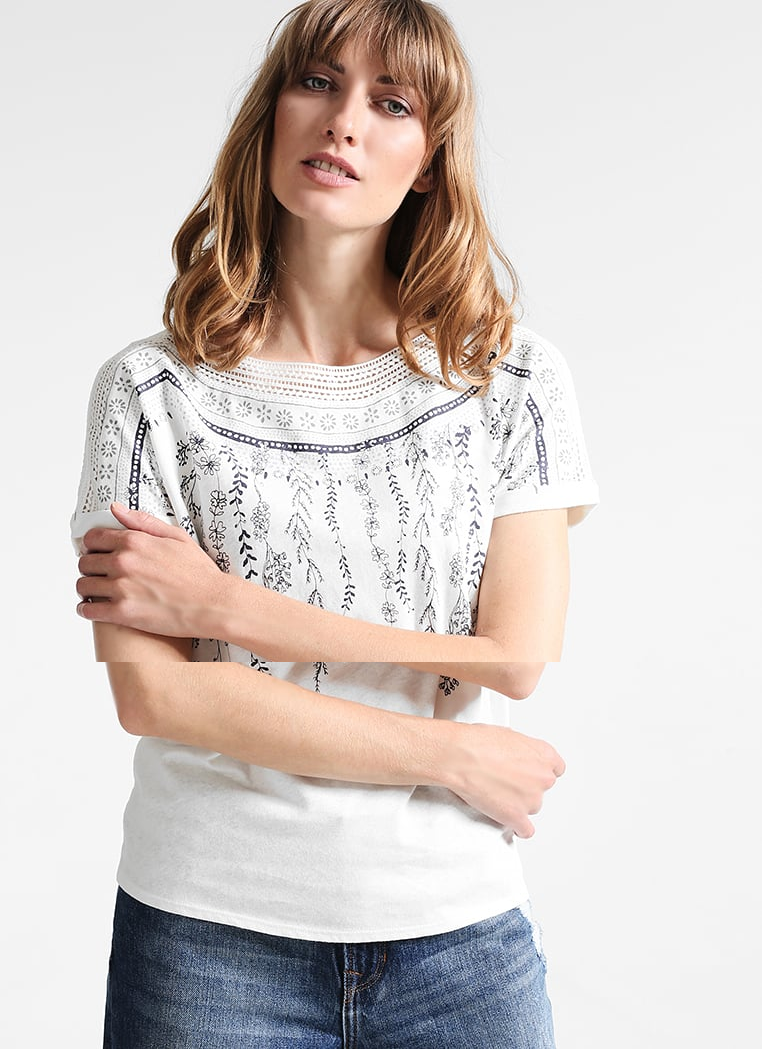

In [ ]:
# Create a mask with the same dimensions as the image
mask = np.zeros((image_height, image_width), dtype=np.uint8)
# mask = input_image.copy()

# Extract the region above the rectangle
region_above = input_image[0:rect_y, :, :]

# Extract the region below the rectangle
region_below = input_image[rect_y + rect_height:, :, :]

# Combine the regions
glued_image = np.vstack((region_above, region_below))

cv2_imshow(glued_image)

# Unrealistic

In [ ]:
# Copy input image
unreal_image = input_image.copy()



cv2_imshow(unreal_image)

# Missing or Extra Body Parts

In [ ]:
# Copy input image
missing_image = input_image.copy()



cv2_imshow(missing_image)

# Eyes & Sunglasses

In [ ]:
# Copy input image
eyes_image = input_image.copy()



cv2_imshow(eyes_image)

# Hair & Face

In [ ]:
# Copy input image
hair_image = input_image.copy()



cv2_imshow(hair_image)

# Random Noise
Just to ruin quality of the image

In [ ]:
import random

def add_random_noise(img, strength):
    noise = np.random.randint(-strength, strength, img.shape, dtype=np.int16)
    noisy_image = np.clip(img + noise, 0, 255).astype(np.uint8)
    return noisy_image

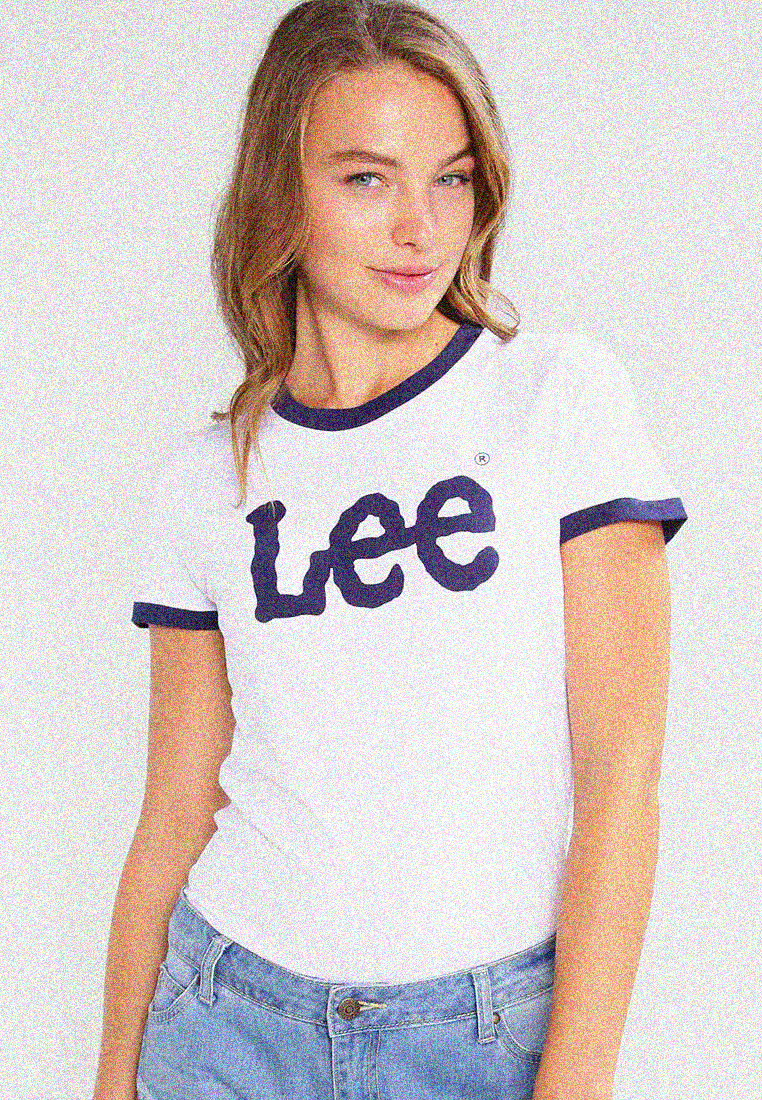

In [ ]:
# Copy input image
noise_image = input_image.copy()

distortion_strength = 50  # Adjust this value to control the strength of distortion
noise_image = add_random_noise(noise_image, distortion_strength)

cv2_imshow(noise_image)

# Unnatural Poses and Expressions

In [ ]:
# Copy input image
unnatural_image = input_image.copy()



cv2_imshow(unnatural_image)

# Over-smoothing or Over-sharpening

In [ ]:
# Copy input image
over_smooth_image = input_image.copy()



cv2_imshow(over_smooth_image)